In [1]:
import tensorflow as tf
import pandas as pd
import regex as re
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
import numpy as np

2023-12-09 18:20:12.786707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the saved model
loaded_model = tf.keras.models.load_model("/Users/jurajsimkovic/Desktop/WU/Bachelorarbeit/model")

In [57]:
# import tweets from Clinton and Trump
df = pd.read_csv('/Users/jurajsimkovic/Desktop/WU/Bachelorarbeit/data/2016_us_election_tweets_100k.csv')

In [58]:
df.head()

,id,candidate_id,tweet_id,polarity,subjectivity,retweet_count,favorite_count,device,retweeted_status_id,lang,state,tweet_text,created_at,inserted_at,updated_at,tw_user_id,latitude,longitude
0,57486,3,770728672433143808,0.000000,0.000000,0,0,1,NaN,tr,NaN,"Ne farkınız var DAIŞ, El-Kaide, El Nusra, YPG ...",2016-08-30T21:03:29,2016-08-30T21:03:29,2016-08-30T21:03:29,NaN,NaN,NaN
1,57536,3,770729424207618048,0.000000,0.000000,0,0,1,NaN,en,NaN,@BarackObama the way you showed up in Louisian...,2016-08-30T21:06:28,2016-08-30T21:06:29,2016-08-30T21:06:29,NaN,NaN,NaN
2,57586,3,770730086978977796,-0.472222,0.555556,0,0,1,NaN,en,NaN,White house not taking tax avoid seriously! Ap...,2016-08-30T21:09:06,2016-08-30T21:09:07,2016-08-30T21:09:07,NaN,NaN,NaN
3,57632,2,770748036972773376,0.000000,0.000000,0,0,0,NaN,en,NaN,"politico: .realDonaldTrump, HillaryClinton ple...",2016-08-30T22:20:26,2016-08-30T22:20:26,2016-08-30T22:20:26,NaN,NaN,NaN
4,57682,1,770748065531723778,-0.125000,0.375000,0,0,5,NaN,en,NaN,She's over due by 250 days. https://t.co/IfOO9...,2016-08-30T22:20:33,2016-08-30T22:20:33,2016-08-30T22:20:33,NaN,NaN,NaN


In [59]:
df.shape

(100000, 18)

In [60]:
df.columns

Index(['id', 'candidate_id', 'tweet_id', 'polarity', 'subjectivity',
       'retweet_count', 'favorite_count', 'device', 'retweeted_status_id',
       'lang', 'state', 'tweet_text', 'created_at', 'inserted_at',
       'updated_at', 'tw_user_id', 'latitude', 'longitude'],
      dtype='object')

In [61]:
# get only text and candidate_id
df = df.drop(['id', 'tweet_id', 'polarity', 'subjectivity',
       'retweet_count', 'favorite_count', 'device', 'retweeted_status_id',
       'lang', 'state', 'inserted_at',
       'updated_at', 'tw_user_id', 'latitude', 'longitude'],axis=1)

In [62]:
df.head()

,candidate_id,tweet_text,created_at
0,3,"Ne farkınız var DAIŞ, El-Kaide, El Nusra, YPG ...",2016-08-30T21:03:29
1,3,@BarackObama the way you showed up in Louisian...,2016-08-30T21:06:28
2,3,White house not taking tax avoid seriously! Ap...,2016-08-30T21:09:06
3,2,"politico: .realDonaldTrump, HillaryClinton ple...",2016-08-30T22:20:26
4,1,She's over due by 250 days. https://t.co/IfOO9...,2016-08-30T22:20:33


In [63]:
# get posts only before 8th of November 2016 - this is the day of the 2016 U.S. Presidential election
df = df[df['created_at'] <= '2016-11-08']

In [64]:
df.tail(20)

,candidate_id,tweet_text,created_at
99719,2,"I'm not against immigration, I'm against ILLEG...",2016-09-01T18:54:01
99720,2,@DJT4PresMAGA @moralesdc @realDonaldTrump\nSur...,2016-09-01T18:54:16
99732,2,BIEN CABRÓN https://t.co/PDZjLqndTN,2016-09-01T20:35:15
99753,2,"We don't get news, we get propaganda from the ...",2016-09-01T18:54:01
99754,1,HillaryClinton lleva delantera y va a ganar......,2016-09-01T18:54:16
99786,1,@jdistaso @Hillary_HQ @BernieSanders @HillaryC...,2016-09-01T18:54:01
99787,2,HillaryClinton lleva delantera y va a ganar......,2016-09-01T18:54:16
99819,1,".@HillaryClinton, The Podesta Group, and Makin...",2016-09-01T18:54:01
99820,1,@Reagan_Girl @HillaryClinton some people just ...,2016-09-01T18:54:16
99851,1,@jamieleecurtis @HillaryClinton @realDonaldTru...,2016-09-01T18:54:02


In [65]:
# drop empty rows
df = df.dropna()

In [66]:
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+','', text) #remove mentions
    text = re.sub(r'#','', text) #remove hash
    text = re.sub(r'https?:\/\/\S+', '', text) #remove hyperlink
    text = re.sub('\s+', ' ', text) #remove new line char
    text = re.sub("\'", "", text) #remove single quotes
    
    return text

In [67]:
df["tweet_text"] = df["tweet_text"].apply(cleantext)

In [68]:
df["tweet_text"].head(15)

0     Ne farkınız var DAIŞ, El-Kaide, El Nusra, YPG ...
1                the way you showed up in Louisiana ???
2     White house not taking tax avoid seriously! Ap...
3     politico: .realDonaldTrump, HillaryClinton ple...
4                           Shes over due by 250 days. 
5     Eight Jamaicans selected for ’s young leaders’...
7      can we just report the results after Election...
8     BarackObama Obama Obama commutes sentences for...
10                                      _ass_Bastard 😂😂
12                            Trumpsters are all fools.
13     "And I see your VOTES," sez HILLARY who only ...
17    Let me s*ck ur d1ldo 👏 😘 Look my top tweet :* ...
18    _Baldasaro I guess calling for the murder of h...
19                                    _ES _es _OEA2015 
20     _Comics you lie like a Democrat. He never ref...
Name: tweet_text, dtype: object

In [69]:
import string
df["tweet_text"] = df["tweet_text"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])

In [70]:
df["tweet_text"] = df["tweet_text"].apply(lambda wrd: ''.join(wrd))

In [71]:
df["tweet_text"]

0        ne farkınız var daiş elkaide el nusra ypg ve p...
1                      the way you showed up in louisiana 
2        white house not taking tax avoid seriously app...
3        politico realdonaldtrump hillaryclinton pledge...
4                               shes over due by 250 days 
                               ...                        
99951     are you now saying that you were in bed with ...
99952     dios no escucha mentiroso que de proposito de...
99983     well its a start  and with as our potus well ...
99984     pls refuse to do forum trap demand loud n cle...
99995                                                     
Name: tweet_text, Length: 44333, dtype: object

In [72]:
from nltk.corpus import stopwords

In [73]:
df["tweet_text"][:50] = df["tweet_text"][:50].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))

/var/folders/2z/g8ydpyhx10zg0sz4jqvhznj00000gn/T/ipykernel_18771/3398030308.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df["tweet_text"][:50] = df["tweet_text"][:50].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))
/var/folders/2z/g8ydpyhx10zg0sz4jqvhznj00000gn/T/ipykernel_18771/3398030308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"][:50] = df["tweet_text"][:50].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))


In [74]:
df["tweet_text"]

0        ne farkınız var daiş elkaide el nusra ypg pkkd...
1                                     way showed louisiana
2        white house taking tax avoid seriously apple d...
3        politico realdonaldtrump hillaryclinton pledge...
4                                        shes due 250 days
                               ...                        
99951     are you now saying that you were in bed with ...
99952     dios no escucha mentiroso que de proposito de...
99983     well its a start  and with as our potus well ...
99984     pls refuse to do forum trap demand loud n cle...
99995                                                     
Name: tweet_text, Length: 44333, dtype: object

In [75]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),     deacc=True))

In [76]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [77]:
temp = []
data_to_list = df["tweet_text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(data_to_list[i])
data_wordslem = list(sent_to_words(temp))

Using Lemmatizer instead of stemming. Lemmatizer is preffered over stemming. Lemmatizer find the root word whereas Stemmizer shorten the word. For Example, word 'Caring' -> Lemmatizer -> 'Care' WHEREAS 'Caring' -> Stemming -> 'Car'

In [78]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

In [79]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jurajsimkovic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [80]:
for i in range(len(data_wordslem)):
    for j in range(len(data_wordslem[i])):
        data_wordslem[i][j] = lemmatizer.lemmatize(data_wordslem[i][j],pos="v")

In [81]:
data = []
for i in range(len(data_wordslem)):
    data.append(detokenize(data_wordslem[i]))
print(data[:5])

['ne farkınız var dais elkaide el nusra ypg pkkdan hepsine silah veriyorsunuz', 'way show louisiana', 'white house take tax avoid seriously apple disgust appletax', 'politico realdonaldtrump hillaryclinton pledge pause campaign getty', 'shes due days']


In [82]:
print(data[:50])

['ne farkınız var dais elkaide el nusra ypg pkkdan hepsine silah veriyorsunuz', 'way show louisiana', 'white house take tax avoid seriously apple disgust appletax', 'politico realdonaldtrump hillaryclinton pledge pause campaign getty', 'shes due days', 'eight jamaicans select young leaders initiative jaminate', 'report result election day poll dont mean anything election corrupt liar', 'barackobama obama obama commute sentence federal prisoners president barac uniteblue tcot', 'assbastard', 'trumpsters fool', 'see vote sez hillary care money power andhillary', 'let sck ur ldo look top tweet wh re', 'baldasaro guess call murder upside', 'es es oea', 'comics lie like democrat never refuse need put rush irs', 'keep real', 'rt rocknkarma realdonaldtrump fit president congratulations clean bill health hillaryclinton hide', 'clinton trump sorry sorry', 'trumptrain', 'senate leaders job do join thousands remind via', 'get five buck trump tweet something stupid anway', 'dont', 'trump ideal sex

In [83]:
df.head()

,candidate_id,tweet_text,created_at
0,3,ne farkınız var daiş elkaide el nusra ypg pkkd...,2016-08-30T21:03:29
1,3,way showed louisiana,2016-08-30T21:06:28
2,3,white house taking tax avoid seriously apple d...,2016-08-30T21:09:06
3,2,politico realdonaldtrump hillaryclinton pledge...,2016-08-30T22:20:26
4,1,shes due 250 days,2016-08-30T22:20:33


In [84]:
# add new cleaned column to dataframe
df["data"] = data
df

,candidate_id,tweet_text,created_at,data
0,3,ne farkınız var daiş elkaide el nusra ypg pkkd...,2016-08-30T21:03:29,ne farkınız var dais elkaide el nusra ypg pkkd...
1,3,way showed louisiana,2016-08-30T21:06:28,way show louisiana
2,3,white house taking tax avoid seriously apple d...,2016-08-30T21:09:06,white house take tax avoid seriously apple dis...
3,2,politico realdonaldtrump hillaryclinton pledge...,2016-08-30T22:20:26,politico realdonaldtrump hillaryclinton pledge...
4,1,shes due 250 days,2016-08-30T22:20:33,shes due days
...,...,...,...,...
99951,1,are you now saying that you were in bed with ...,2016-09-01T18:54:02,be you now say that you be in bed with hillary...
99952,2,dios no escucha mentiroso que de proposito de...,2016-09-01T18:54:18,dios no escucha mentiroso que de proposito def...
99983,2,well its a start and with as our potus well ...,2016-09-01T18:54:02,well its start and with as our potus well be d...
99984,2,pls refuse to do forum trap demand loud n cle...,2016-09-01T18:54:18,pls refuse to do forum trap demand loud clear ...


In [85]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    0 1902  200]
 [   0    0    0 ...  145  116 1405]
 [   0    0    0 ...  828 1684  737]
 ...
 [   0    0    0 ...    2  152 2092]
 [   0    0    0 ...  138 3213 3010]
 [   0    0    0 ...    0    0    0]]


In [86]:
df.shape

(44333, 4)

In [42]:
# apply the model
#predictions = loaded_model.predict(tweets)

202/202 [==============================] - 3s 8ms/step


In [87]:
sentiment = ['Neutral','Negative','Positive']

In [88]:
sequence = tokenizer.texts_to_sequences(['I go to gym daily'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(loaded_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 893ms/step


'Neutral'

In [89]:
def sentiment_analysis(data):
    sentiment_storage = []
    for d in data:
        sequence = tokenizer.texts_to_sequences([d])        
        test = pad_sequences(sequence, maxlen=max_len)
        sentiment_storage.append(sentiment[np.around(loaded_model.predict(test), decimals=0).argmax(axis=1)[0]])
    return sentiment_storage

In [90]:
for d in data[:5]:
    print(d)
    print("-----------------")

ne farkınız var dais elkaide el nusra ypg pkkdan hepsine silah veriyorsunuz
-----------------
way show louisiana
-----------------
white house take tax avoid seriously apple disgust appletax
-----------------
politico realdonaldtrump hillaryclinton pledge pause campaign getty
-----------------
shes due days
-----------------


In [97]:
#predicted_sentiment = sentiment_analysis(data[:15])

1/1 [==============================] - 0s 24ms/step


In [92]:
# filter by candidates - select only Donald Trump and Hillary Clinton

# Hillary Clinton
HC = df[df["candidate_id"] == 1]

# Donald Trump
DT = df[df["candidate_id"] == 2]

In [100]:
DT.head(15)

,candidate_id,tweet_text,created_at,data
3,2,politico realdonaldtrump hillaryclinton pledge...,2016-08-30T22:20:26,politico realdonaldtrump hillaryclinton pledge...
10,2,assbastard 😂😂,2016-08-30T22:21:22,assbastard
12,2,trumpsters fools,2016-08-30T22:21:41,trumpsters fool
17,2,let sck ur d1ldo 👏 😘 look top tweet wh0re,2016-08-30T22:22:23,let sck ur ldo look top tweet wh re
20,2,comics lie like democrat never refused need pu...,2016-08-30T22:22:46,comics lie like democrat never refuse need put...
24,2,035 keeps real,2016-08-30T22:23:20,keep real
26,2,clinton trump sorry sorry,2016-08-30T22:23:34,clinton trump sorry sorry
28,2,werenotgonnatakeitanymore trumptrain makeameri...,2016-08-30T22:23:47,trumptrain
30,2,got five bucks trump tweets something stupid a...,2016-08-30T22:23:59,get five buck trump tweet something stupid anway
46,2,trumps ideal sex slave,2016-08-30T22:20:33,trump ideal sex slave


In [94]:
HC.shape

(14177, 4)

In [95]:
DT.shape

(25891, 4)

In [98]:
predicted_sentiment

['Negative',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Neutral',
 'Positive',
 'Neutral',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral']

In [ ]:
# This took a very long time (45min - 1hr). It predicted the sentiment of each
# of the approximately 6600 Twitter posts.

predicted_sentiment_hillary = sentiment_analysis(data)

In [154]:
text_handle["predicted_sentiment"] = predicted_sentiment

In [159]:
text_handle

,handle,text,data,predicted_sentiment
0,HillaryClinton,The question election: Who put plans action ma...,the question election who put plan action make...,Neutral
1,HillaryClinton,"Last night, Donald Trump said paying taxes ""sm...",last night donald trump say pay tax smart you ...,Neutral
2,HillaryClinton,Couldnt proud . Her vision command last nights...,couldnt proud her vision command last nights d...,Neutral
3,HillaryClinton,"If stand together, theres nothing cant do. Mak...",if stand together theres nothing cant do make ...,Neutral
4,HillaryClinton,Both candidates asked theyd confront racial in...,both candidates ask theyd confront racial inju...,Negative
...,...,...,...,...
6439,realDonaldTrump,""": My Facebook Groups are all voting TRUMP /40...",my facebook group be all vote trump people great,Positive
6440,realDonaldTrump,""": watched lowell mass speech. Awesome. Great ...",watch lowell mass speech awesome great crowd m...,Neutral
6441,realDonaldTrump,"""_lol: Iowa key endorsement for Cant wait for ...",iowa key endorsement for cant wait for the iow...,Neutral
6442,realDonaldTrump,""": Minimizing dependency on China is crucial.O...",minimize dependency on china be crucial only t...,Positive


# Visualize the results

In [170]:
hillary_positive_sentiment = text_handle[(text_handle['handle'] == 'HillaryClinton') & (text_handle['predicted_sentiment'] == 'Positive')]
hillary_positive_sentiment

,handle,text,data,predicted_sentiment
32,HillaryClinton,“Donald criticized preparing debate. And know ...,donald criticize prepare debate and know else ...,Positive
38,HillaryClinton,"""She gained massive amount weight...it real pr...",she gain massive amount weight it real problem...,Positive
51,HillaryClinton,"Trump on Alicia, 1996: ""Miss Piggy."" This morn...",trump on alicia miss piggy this morning she ga...,Positive
67,HillaryClinton,43 days left. Let’s go win this thing: DebateN...,days leave let go win this thing debatenight,Positive
74,HillaryClinton,Hillary Clinton did what she needed to do:,hillary clinton do what she need to do,Positive
...,...,...,...,...
4785,HillaryClinton,Trump saying awful things about women isnt the...,trump say awful things about women isnt the mo...,Positive
4801,HillaryClinton,. Reflects On s Passing w/ Prince HillaryClinton,reflect on pass prince hillaryclinton,Positive
4816,HillaryClinton,"Thank you, New York. Lets go win this nominati...",thank you new york let go win this nomination,Positive
4839,HillaryClinton,"It’s about lifting each other up, not tearing ...",it about lift each other up not tear each othe...,Positive


In [175]:
# group by each candidate and each sentiment
hillary_negative_sentiment = text_handle[(text_handle['handle'] == 'HillaryClinton') & (text_handle['predicted_sentiment'] == 'Negative')]
hillary_neutral_sentiment = text_handle[(text_handle['handle'] == 'HillaryClinton') & (text_handle['predicted_sentiment'] == 'Neutral')]
trump_negative_sentiment = text_handle[(text_handle['handle'] == 'realDonaldTrump') & (text_handle['predicted_sentiment'] == 'Negative')]
trump_positive_sentiment = text_handle[(text_handle['handle'] == 'realDonaldTrump') & (text_handle['predicted_sentiment'] == 'Positive')]
trump_neutral_sentiment = text_handle[(text_handle['handle'] == 'realDonaldTrump') & (text_handle['predicted_sentiment'] == 'Neutral')]

Text(0.5, 1.0, 'Polarity of posts of each candidate')

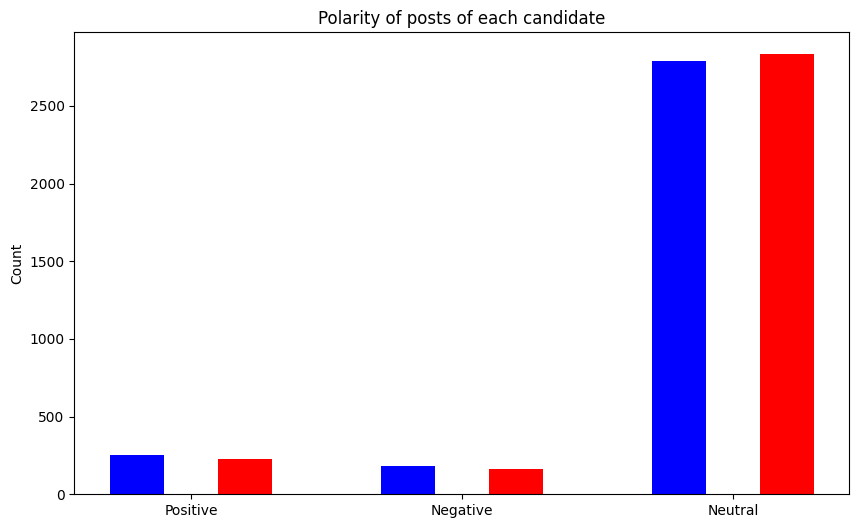

In [178]:
# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars for Hillary Clinton
bar_width = 0.2
bar_positions_hillary = range(1, 4)
ax.bar([p - bar_width for p in bar_positions_hillary], [len(hillary_positive_sentiment), len(hillary_negative_sentiment), len(hillary_neutral_sentiment)], width=bar_width, label='Hillary Clinton', color='blue')

# Plotting bars for Donald Trump
bar_positions_trump = range(1, 4)
ax.bar([p + bar_width for p in bar_positions_trump], [len(trump_positive_sentiment), len(trump_negative_sentiment), len(trump_neutral_sentiment)], width=bar_width, label='Donald Trump', color='red')

# Set labels and title
ax.set_xticks([p for p in bar_positions_hillary])
ax.set_xticklabels(['Positive', 'Negative', 'Neutral'])
ax.set_ylabel('Count')
ax.set_title('Polarity of posts of each candidate')